<a href="https://colab.research.google.com/github/ItS-arMan/BoW/blob/master/CNA_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
from community import community_louvain
from matplotlib import cm
from networkx.algorithms.community import label_propagation_communities
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import networkx as nx
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the datasets and visualization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Enron Email Graph ---
Number of nodes: 143
Number of edges: 623
Is connected: True


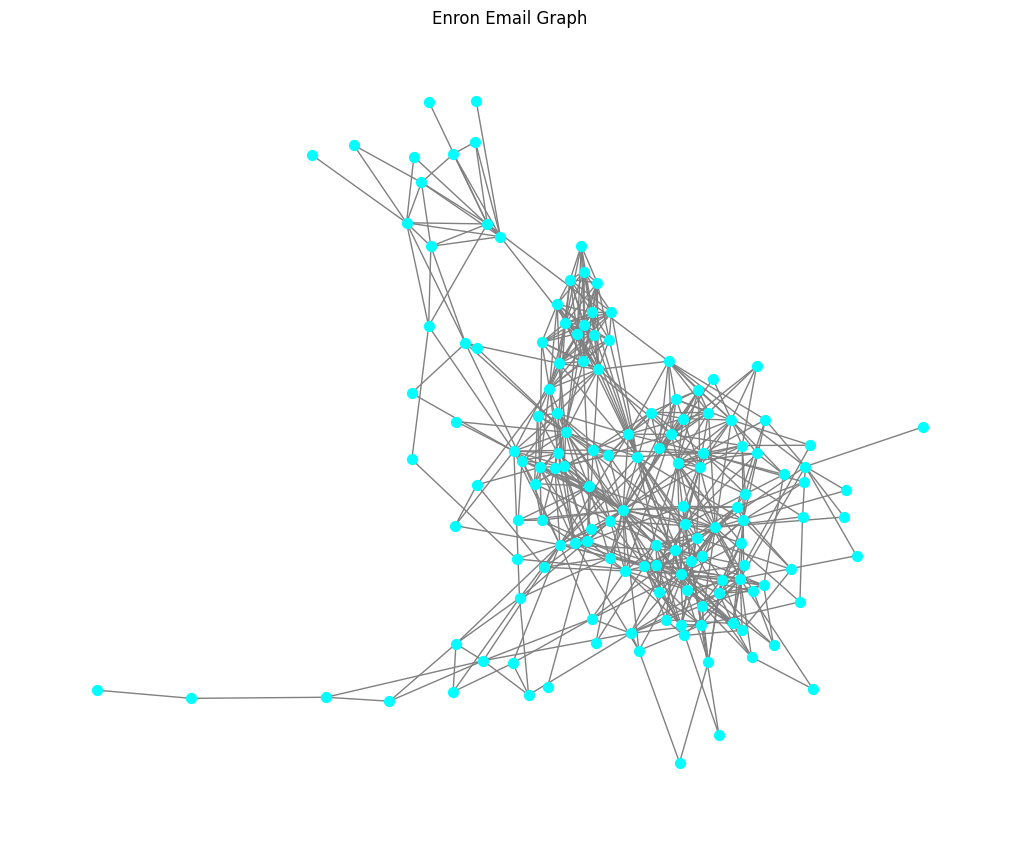

--- Football Graph ---
Number of nodes: 35
Number of edges: 118
Is connected: True


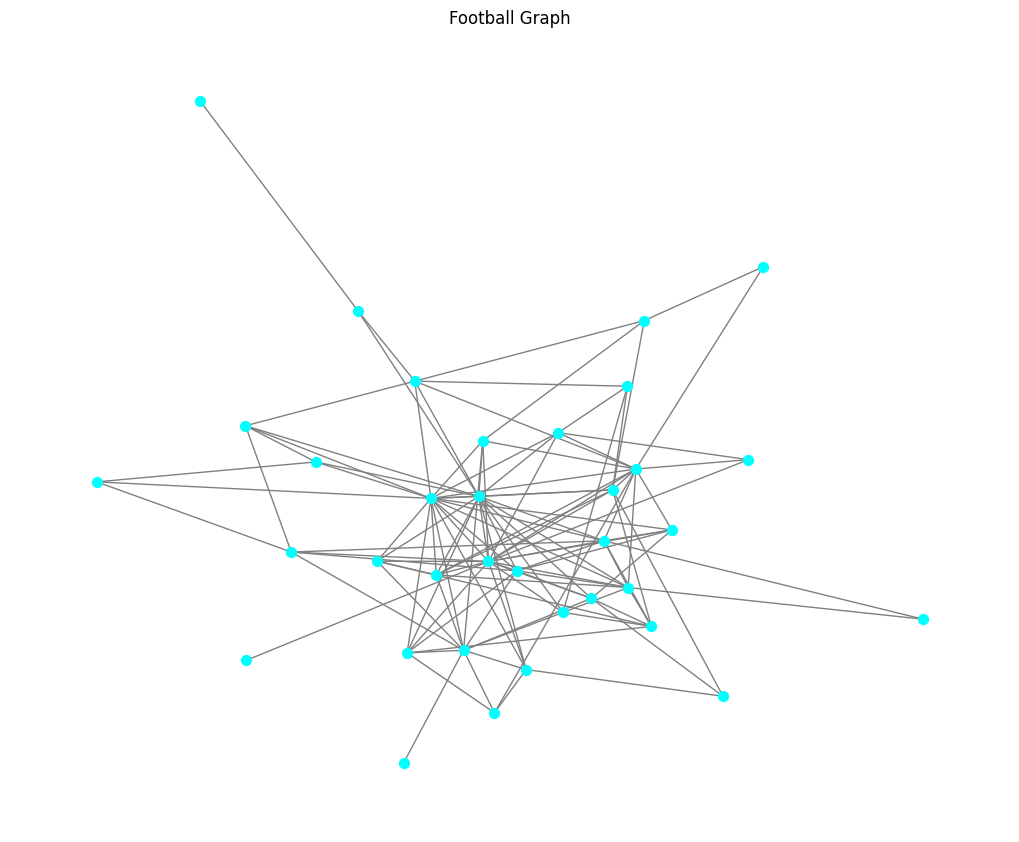

--- Jazz Graph ---
Number of nodes: 198
Number of edges: 2742
Is connected: True


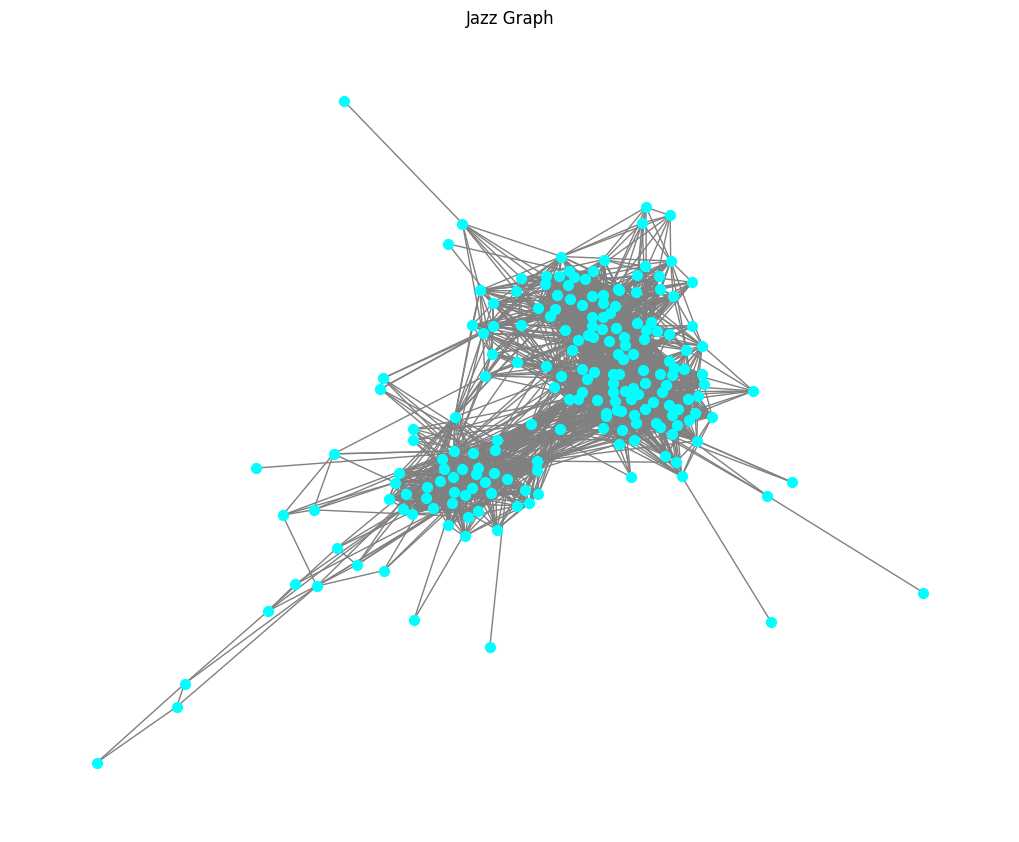

--- ReTweet Graph ---
Number of nodes: 96
Number of edges: 117
Is connected: True


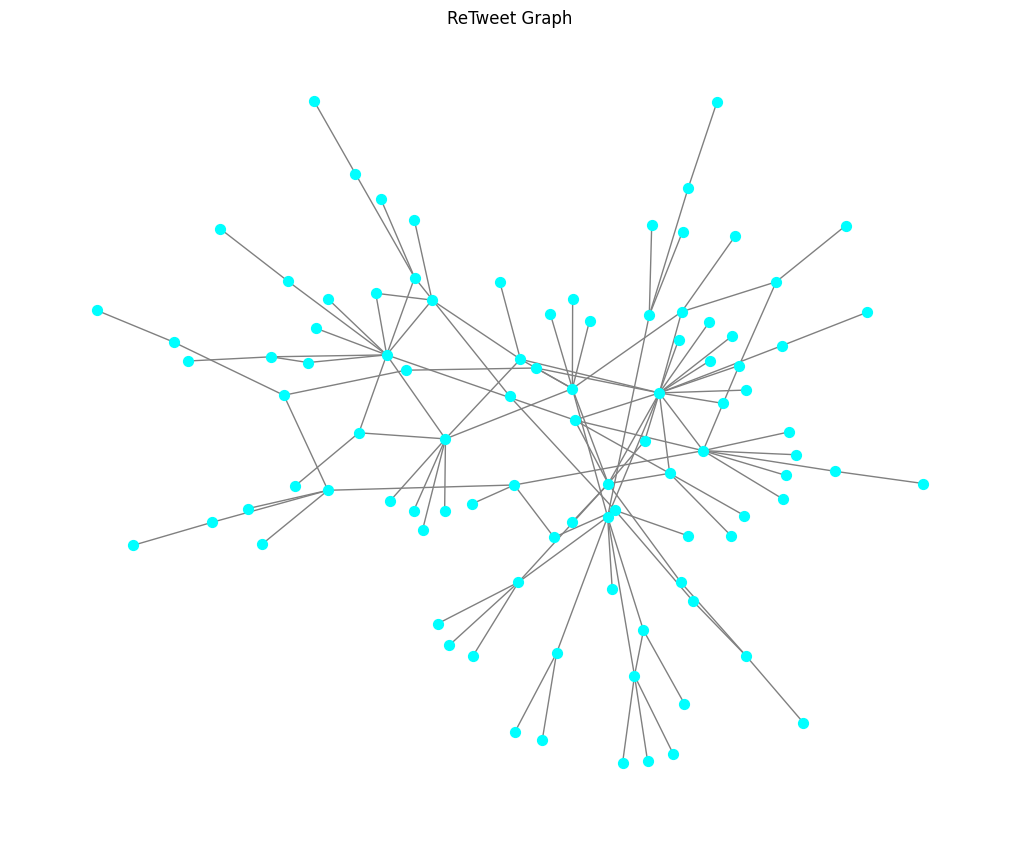

In [50]:
def load_mtx_graph(path):
    sparse_matrix = mmread(path)
    graph = nx.from_scipy_sparse_array(sparse_matrix)
    graph.remove_edges_from(nx.selfloop_edges(graph))
    return graph

def visualize_graph(graph, title):
    print(f"--- {title} ---")
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")
    print(f"Is connected: {nx.is_connected(graph)}")

    pos = nx.spring_layout(graph)
    plt.figure(figsize=(10, 8))
    nx.draw(
        graph,
        pos,
        with_labels=False,
        node_color='cyan',
        edge_color='gray',
        node_size=50
    )
    plt.title(title)
    plt.show()
drive.mount('/content/drive')
enron_email = load_mtx_graph("/content/drive/MyDrive/Colab Notebooks/Dataset/email-enron-only.mtx")
football = load_mtx_graph("/content/drive/MyDrive/Colab Notebooks/Dataset/football.mtx")
jazz = load_mtx_graph("/content/drive/MyDrive/Colab Notebooks/Dataset/jazz.mtx")
retweet = load_mtx_graph("/content/drive/MyDrive/Colab Notebooks/Dataset/rt-retweet.mtx")

visualize_graph(enron_email, "Enron Email Graph")
visualize_graph(football, "Football Graph")
visualize_graph(jazz, "Jazz Graph")
visualize_graph(retweet, "ReTweet Graph")


## Extracts 10 features for the nodes in the graph.
## Returns a pandas DataFrame where rows are nodes and columns are features.

In [51]:
def extract_features(graph):

    features = {}
    # Centrality Measures
    features['degree_centrality'] = nx.degree_centrality(graph)
    features['closeness_centrality'] = nx.closeness_centrality(graph)
    features['betweenness_centrality'] = nx.betweenness_centrality(graph)
    features['eigenvector_centrality'] = nx.eigenvector_centrality(graph)

    features["avg_clustering_coefficient"] = nx.average_clustering(graph)

    # Global Clustering Coefficient (Transitivity)
    features["global_clustering_coefficient"] = nx.transitivity(graph)

    # Network Entropy (based on degree distribution)
    degree_sequence = [d for n, d in graph.degree()]
    degree_probabilities = np.array(degree_sequence) / sum(degree_sequence)
    network_entropy = -np.sum(degree_probabilities * np.log(degree_probabilities)) if all(degree_probabilities > 0) else None
    features["network_entropy"] = network_entropy
    features['pagerank'] = nx.pagerank(graph)

    adj_matrix = nx.to_numpy_array(graph)
    cosine_sim_matrix = cosine_similarity(adj_matrix)
    nodes = list(graph.nodes())
    cosine_sim_aggregated = {u: 0 for u in nodes}
    for i, u in enumerate(nodes):
        cosine_sim_aggregated[u] = cosine_sim_matrix[i].mean()  # Average similarity per node

    features['cosine_similarity'] = cosine_sim_aggregated

    try:
        hubs, authorities = nx.hits(graph, max_iter=1000, tol=1e-8)
        features["avg_hub_score"] = sum(hubs.values()) / len(hubs)
        features["avg_authority_score"] = sum(authorities.values()) / len(authorities)
    except Exception as e:
        features["avg_hub_score"] = None
        features["avg_authority_score"] = None
        print(f"HITS centrality calculation failed: {e}")

    feature_df = pd.DataFrame(features)
    return feature_df

football_features = extract_features(football)
enron_email_features = extract_features(enron_email)
jazz_features = extract_features(jazz)
retweet_features = extract_features(retweet)

In [52]:
def pca(feature_df, n_components=5):
    scaler = StandardScaler()
    feature_matrix = scaler.fit_transform(feature_df)

    pca = PCA(n_components)
    reduced_features = pca.fit_transform(feature_matrix)

    reduced_feature_df = pd.DataFrame(
        reduced_features,
        columns=[f'Feature_{i+1}' for i in range(n_components)]
    )
    reduced_feature_df.index = feature_df.index  # Match node indices
    return reduced_feature_df

football_pca = pca(football_features)
enron_email_pca = pca(enron_email_features)
jazz_pca = pca(jazz_features)
retweet_pca = pca(retweet_features)

In [53]:
def evaluation (graph, pca):

    partition_original = community_louvain.best_partition(graph)
    kmeans_pca = KMeans(n_clusters=len(set(partition_original.values())), random_state=42)
    labels_pca = kmeans_pca.fit_predict(pca)

    labels_original = list(partition_original.values())

    nmi = normalized_mutual_info_score(labels_original, labels_pca)
    ari = adjusted_rand_score(labels_original, labels_pca)


    print("\nNMI (PCA):", nmi, "| ARI (PCA):", ari)


evaluation(football, football_pca)
evaluation(enron_email, enron_email_pca)
evaluation(jazz, jazz_pca)
evaluation(retweet, retweet_pca)


NMI (PCA): 0.09166201976416505 | ARI (PCA): -0.0360648253823328

NMI (PCA): 0.2858255355836502 | ARI (PCA): 0.11534200190690498

NMI (PCA): 0.05123211647885934 | ARI (PCA): 0.05059531794600369

NMI (PCA): 0.2952389974902321 | ARI (PCA): 0.09848419298821039


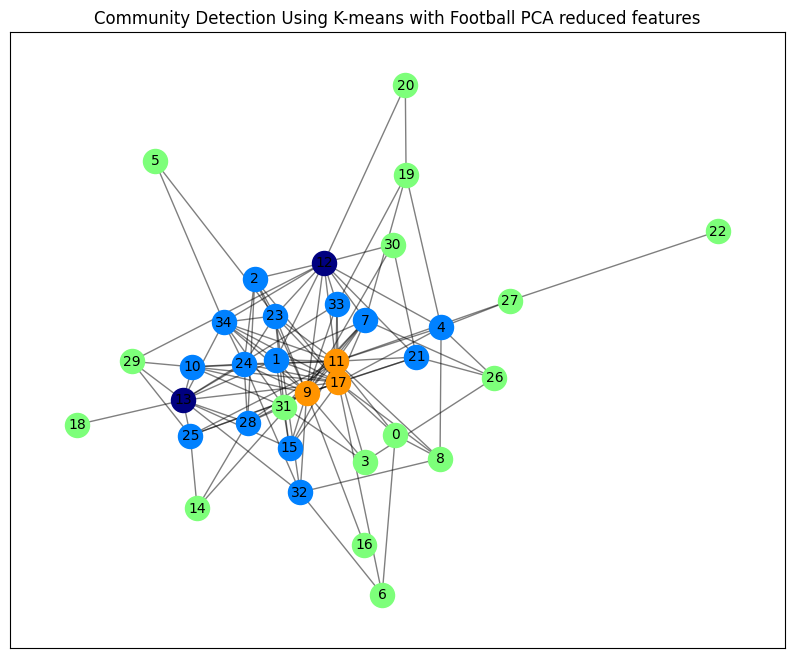

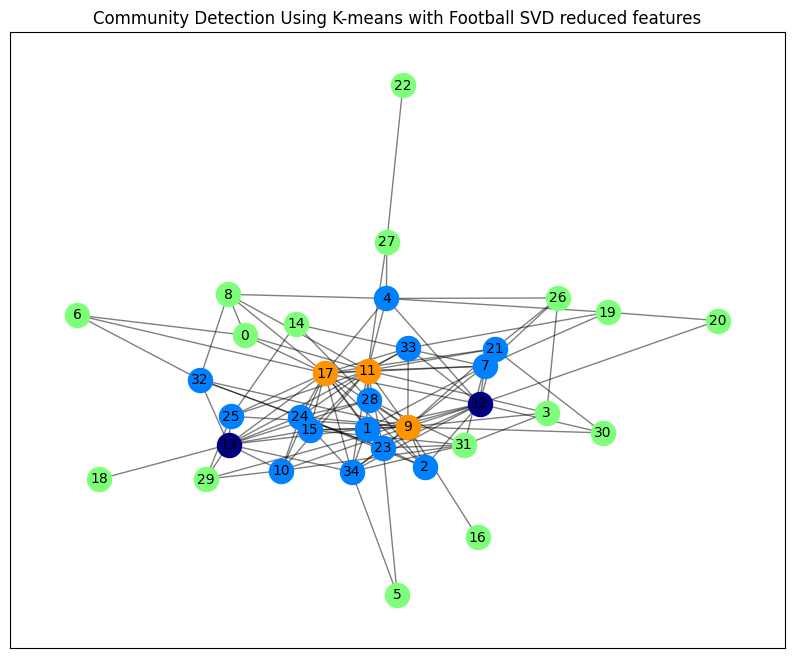

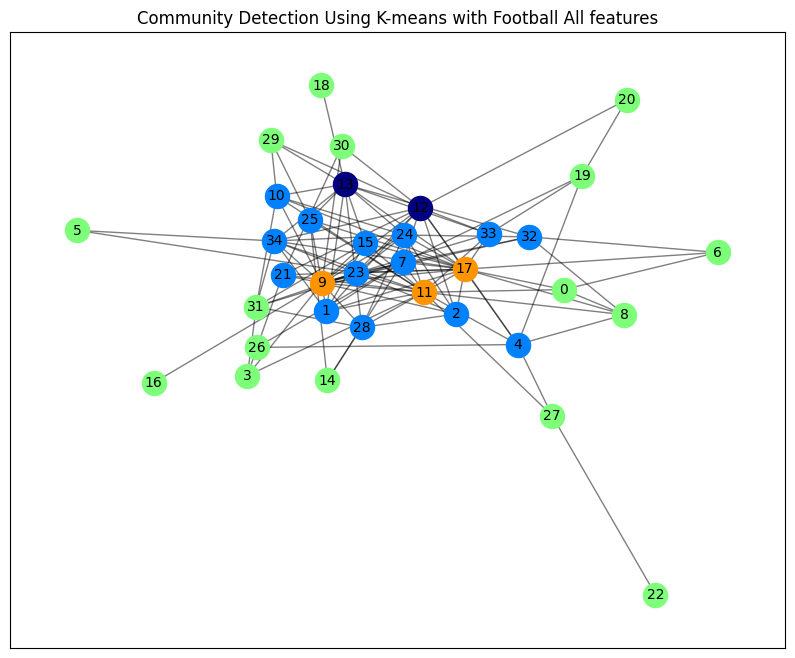

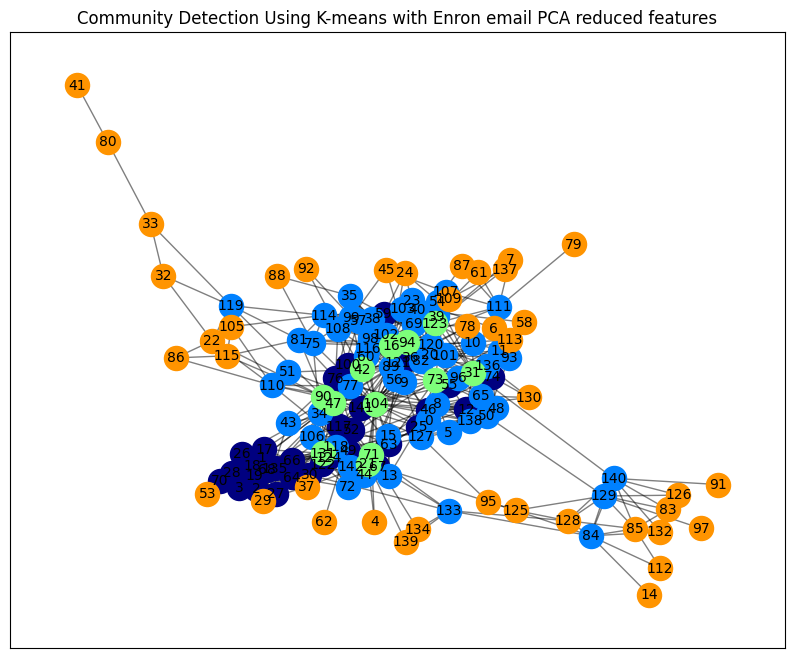

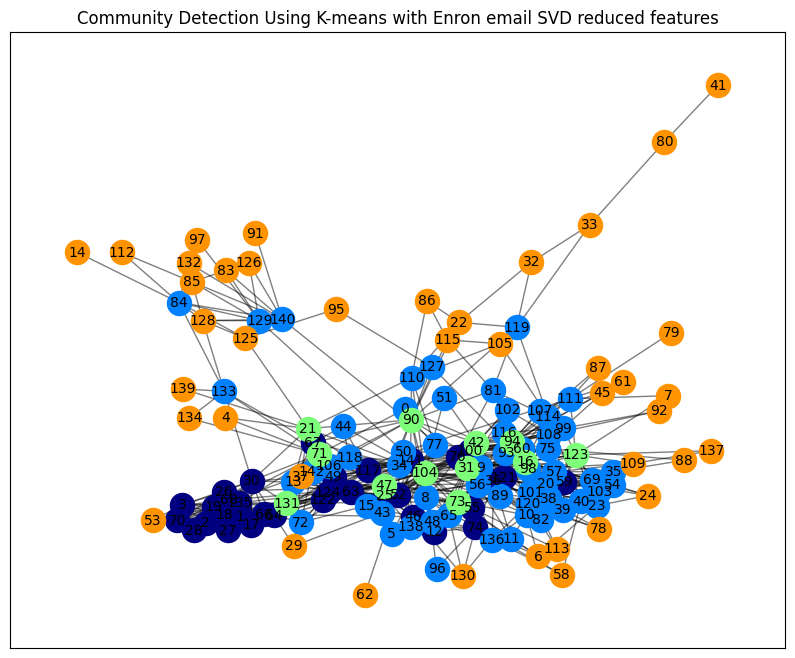

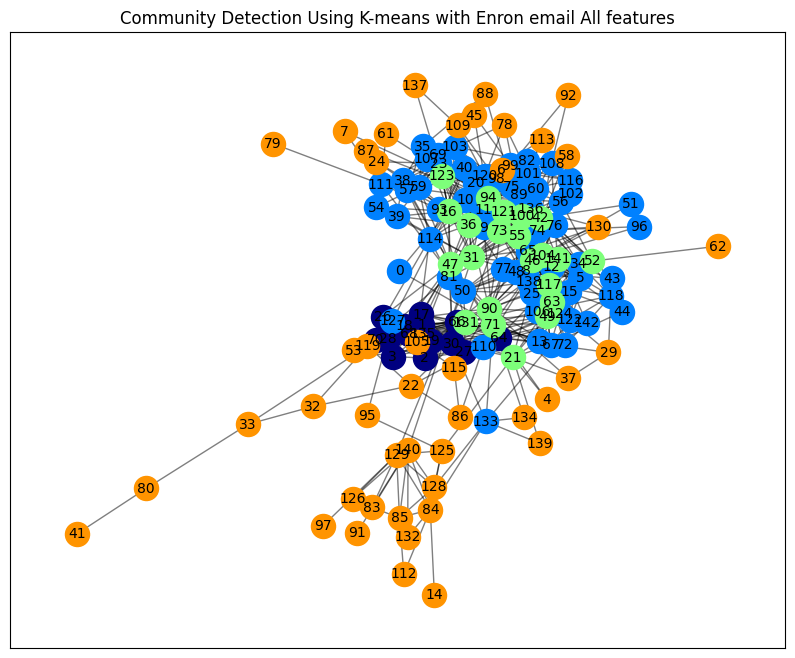

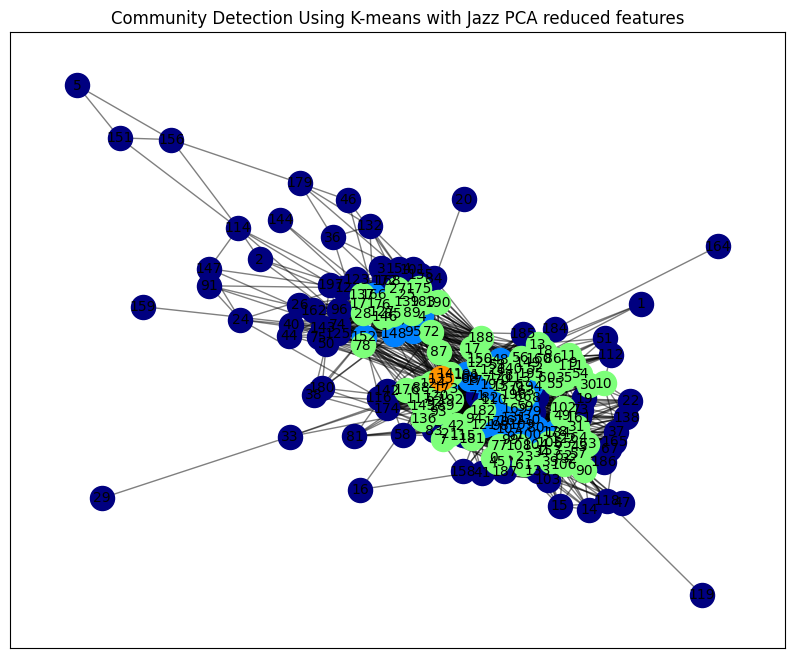

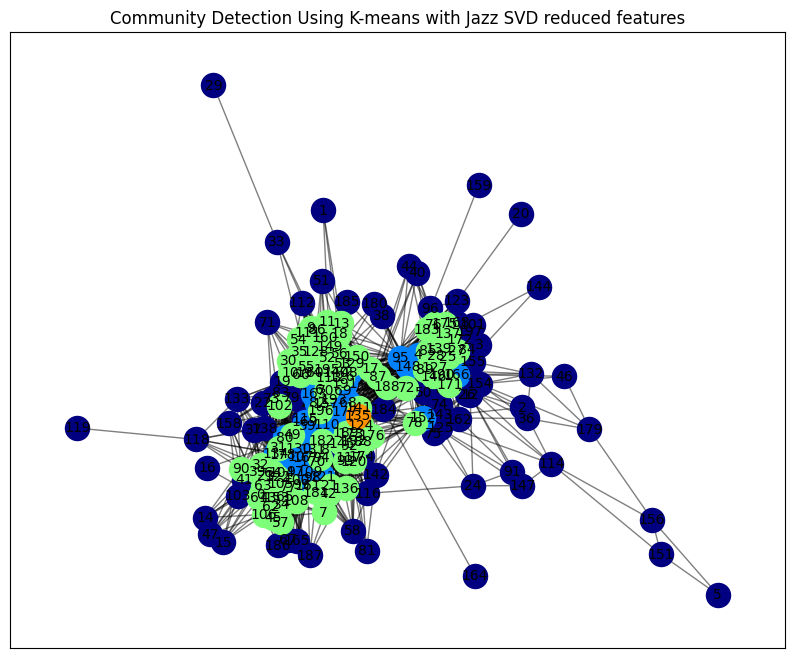

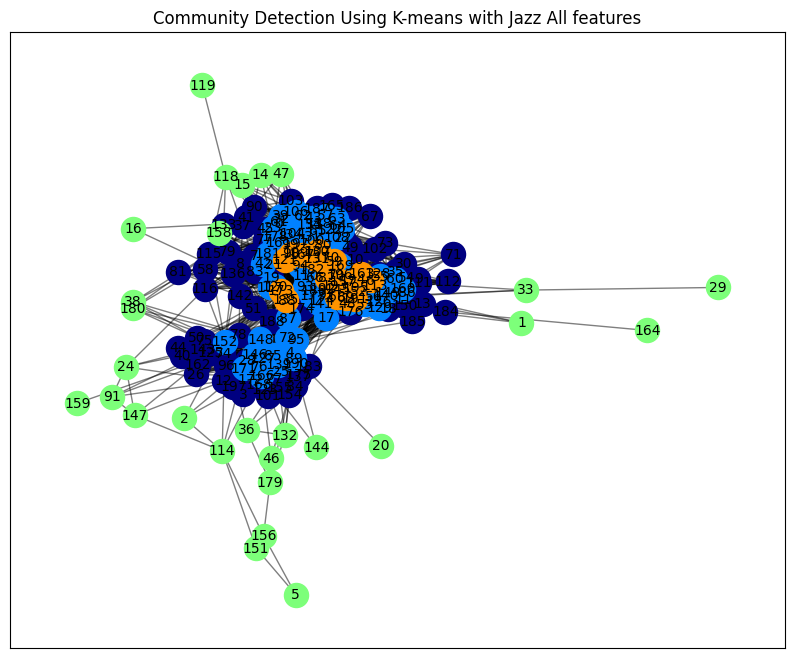

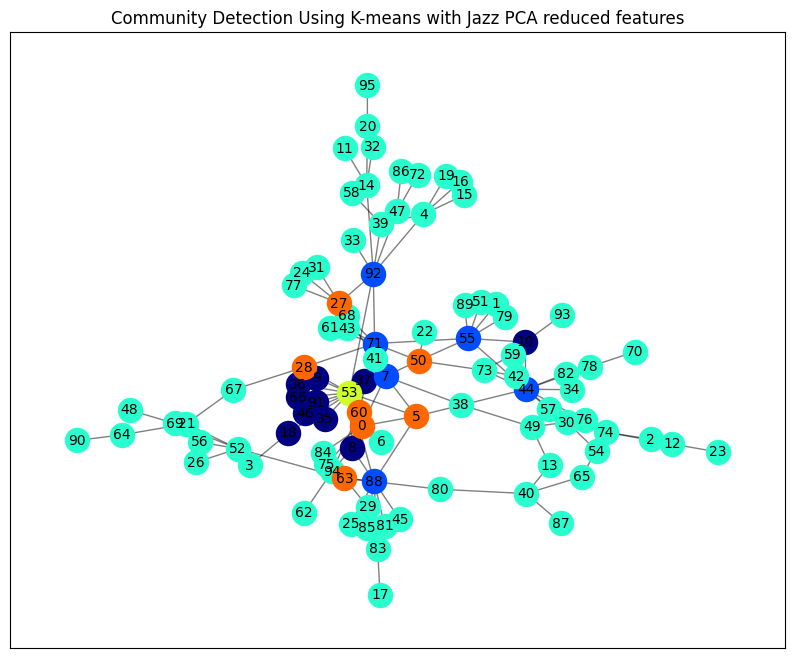

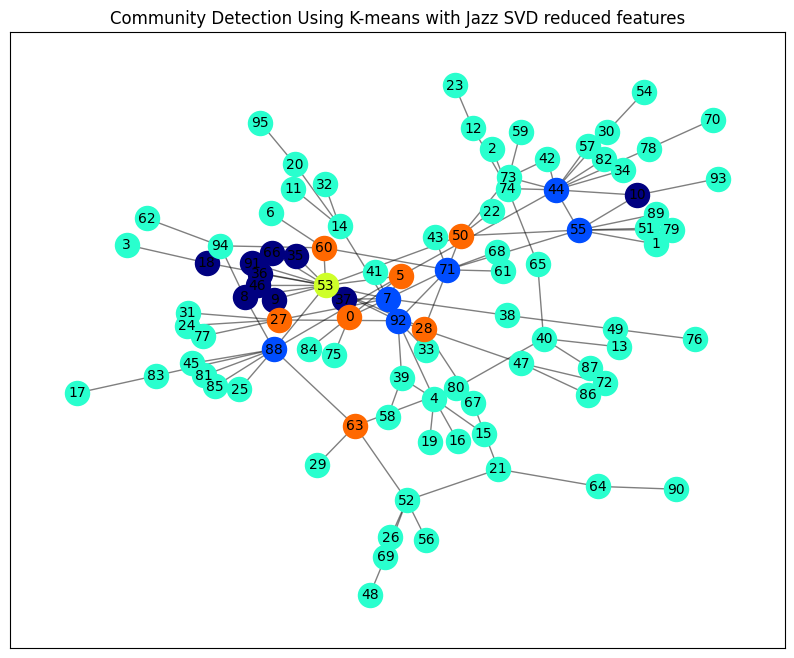

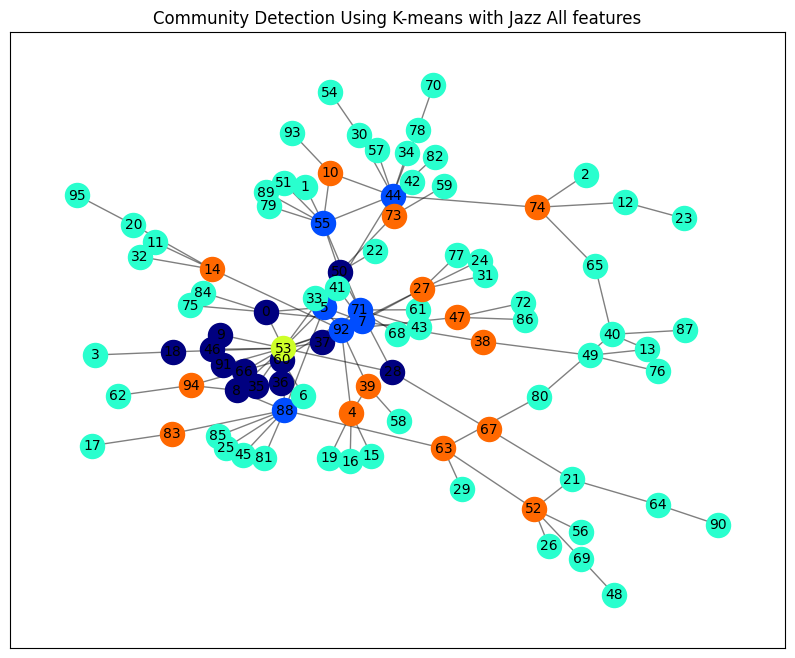

In [54]:
def detect_communities(graph, features,  num_clusters, title):

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(features)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph)

    for community in range(num_clusters):
        nodes_in_community = [node for node, label in zip(graph.nodes(), labels) if label == community]
        nx.draw_networkx_nodes(
            graph, pos,
            nodelist=nodes_in_community,
            node_size=300,
            node_color=[plt.cm.jet(community / num_clusters)],
        )

    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_color="black")
    plt.title(f"Community Detection Using K-means with {title}")
    plt.show()


detect_communities(football, football_pca, 4, "Football PCA reduced features")
detect_communities(football, football_svd, 4, "Football SVD reduced features")
detect_communities(football, football_features, 4, "Football All features")

detect_communities(enron_email, enron_email_pca, 4, "Enron email PCA reduced features")
detect_communities(enron_email, enron_email_svd, 4, "Enron email SVD reduced features")
detect_communities(enron_email, enron_email_features, 4, "Enron email All features")

detect_communities(jazz, jazz_pca, 4, "Jazz PCA reduced features")
detect_communities(jazz, jazz_svd, 4, "Jazz SVD reduced features")
detect_communities(jazz, jazz_features, 4, "Jazz All features")

detect_communities(retweet, retweet_pca, 5, "Jazz PCA reduced features")
detect_communities(retweet, retweet_svd, 5, "Jazz SVD reduced features")
detect_communities(retweet, retweet_features, 5, "Jazz All features")

<ipython-input-55-dfb45a1374ee>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


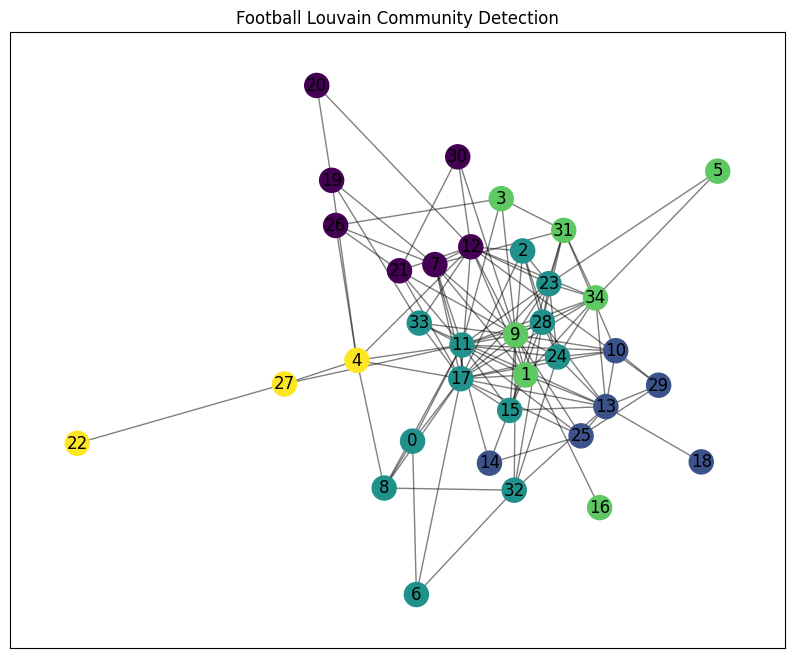

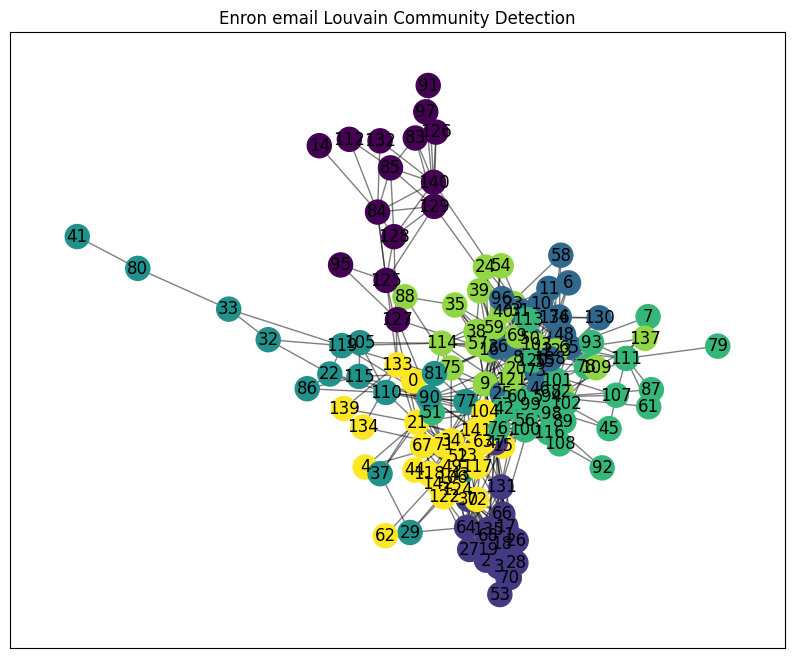

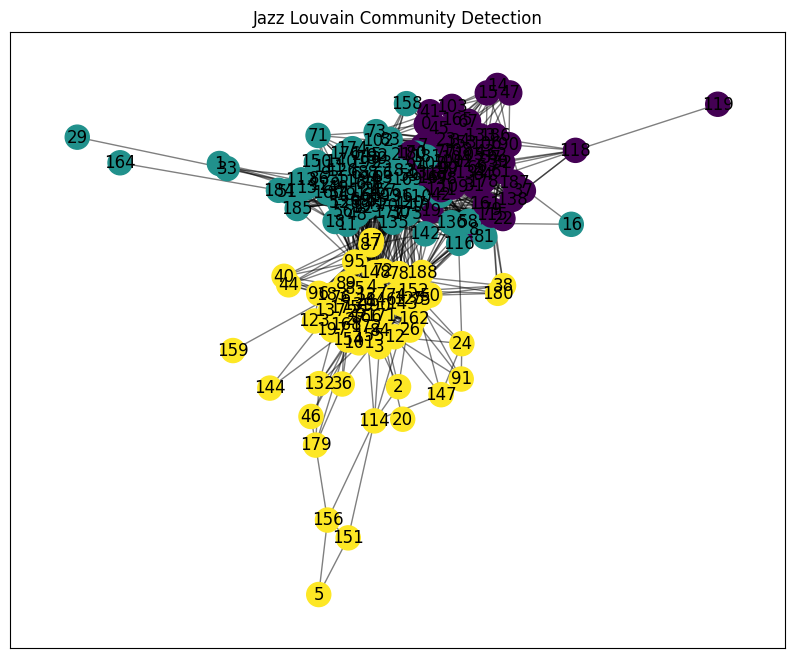

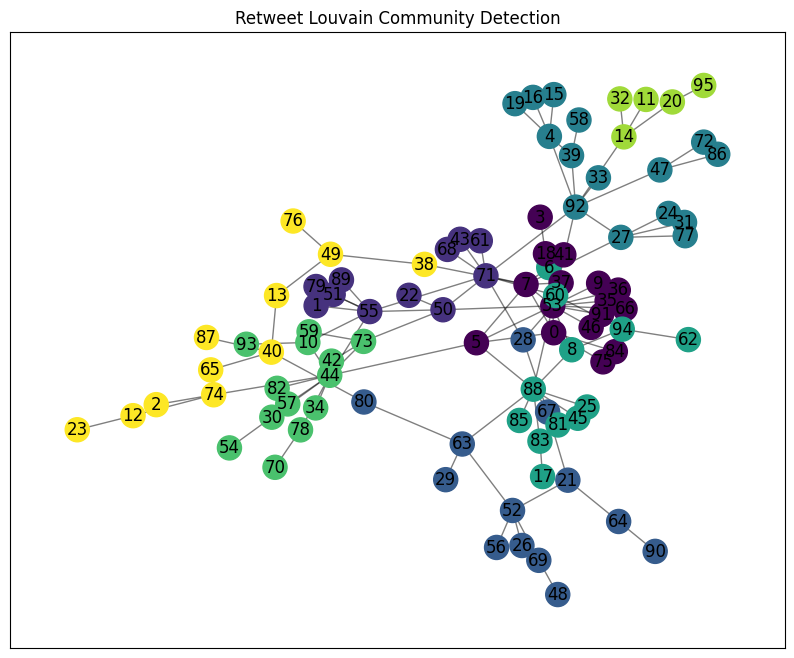

In [55]:
def louvain_community_detection (graph, title):
    # compute the best partition
    partition = community_louvain.best_partition(graph)

    # draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph)
    nx.draw_networkx_labels(graph, pos)
    plt.title(f"{title} Louvain Community Detection")
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(graph, pos, partition.keys(), node_size=300,
                       cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    plt.show()

louvain_community_detection(football, "Football")
louvain_community_detection(enron_email, "Enron email")
louvain_community_detection(jazz, "Jazz")
louvain_community_detection(retweet, "Retweet")


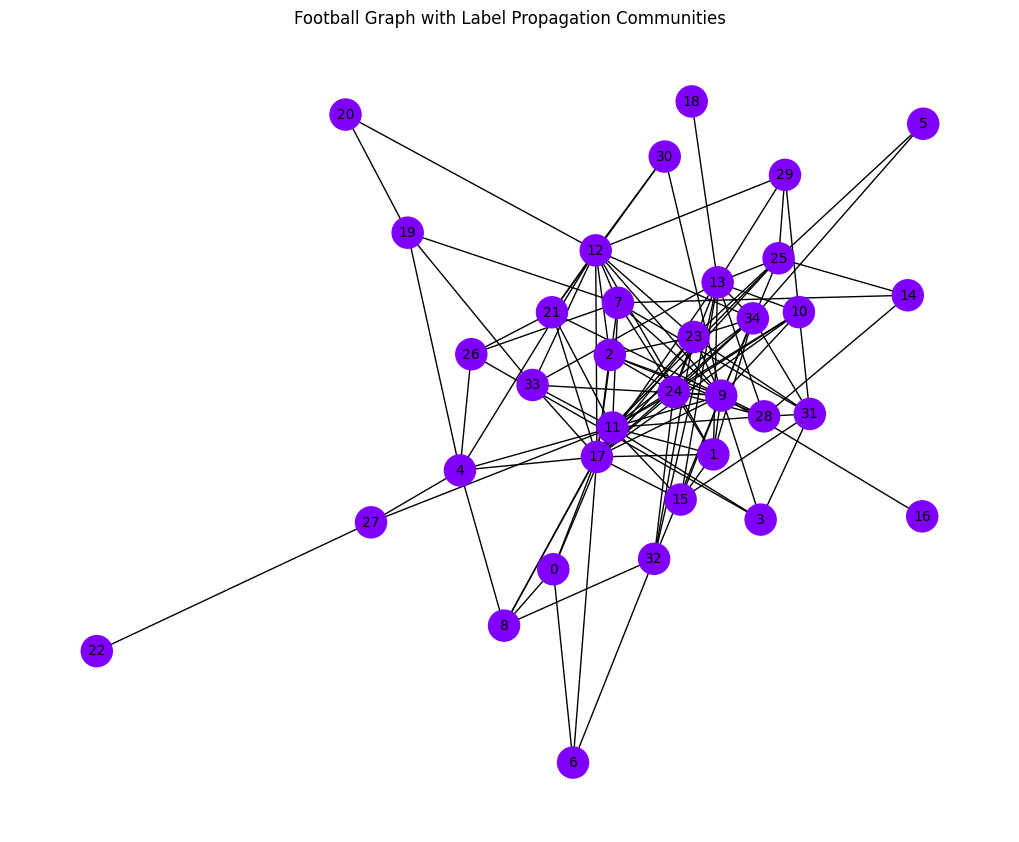

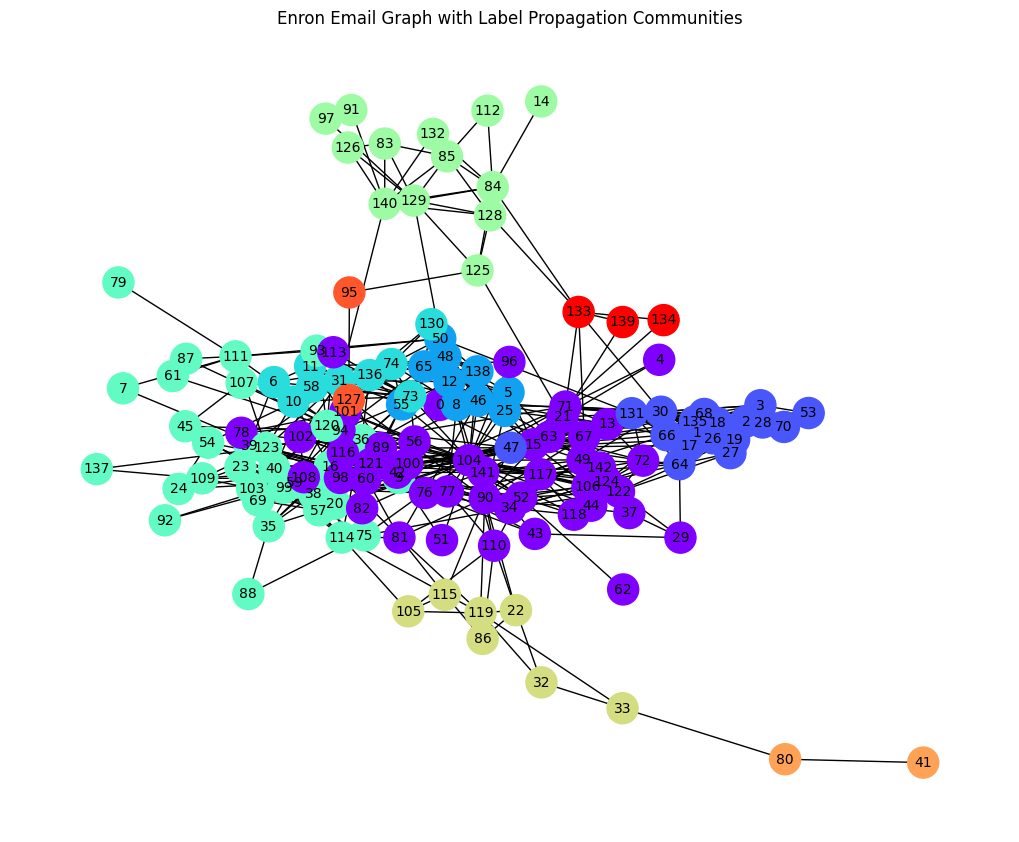

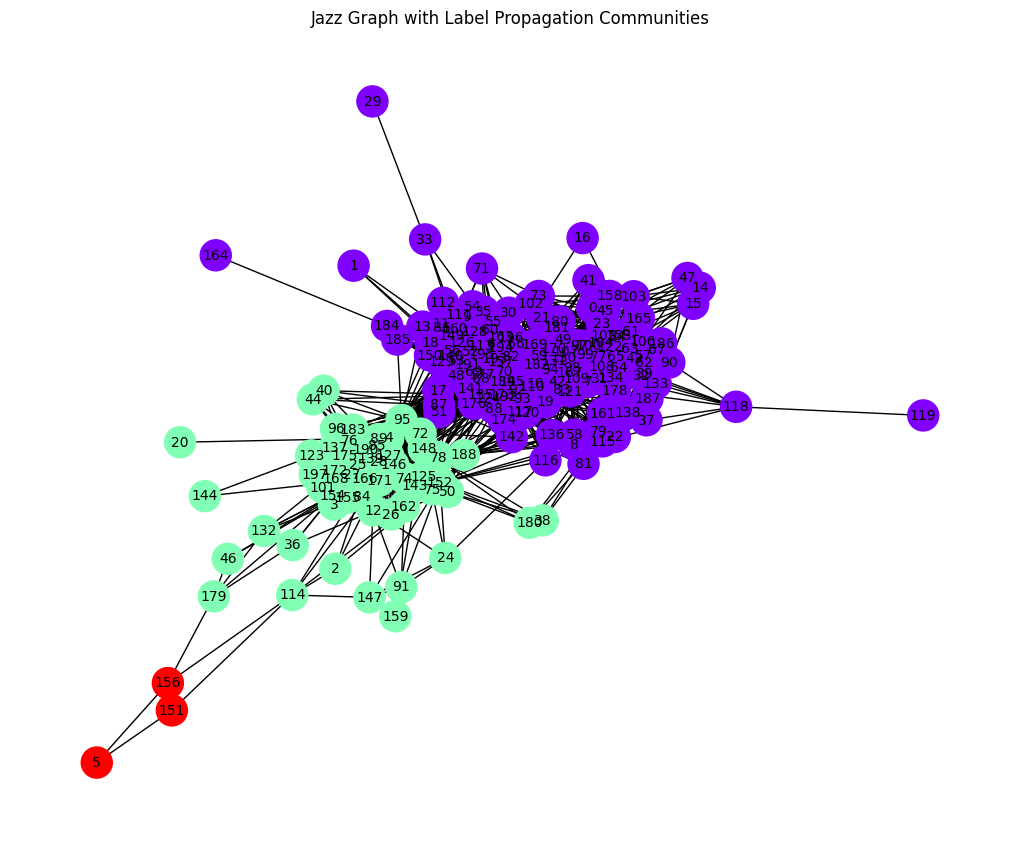

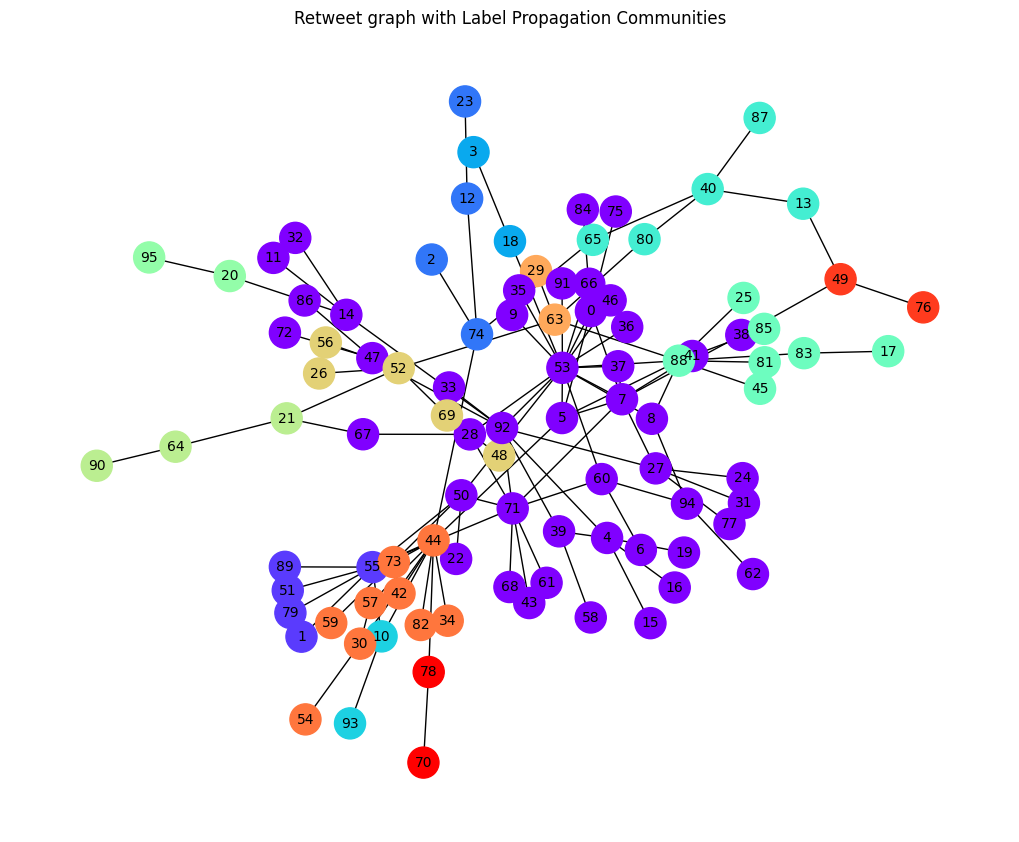

In [56]:
def lpa (graph, title):
    # Use Label Propagation to detect communities
    communities = label_propagation_communities(graph)

    # Create a mapping of node to community label
    community_map = {}
    for i, community in enumerate(communities):
        for node in community:
            community_map[node] = i  # Assign the community number to each node

# Assign colors based on community
    node_colors = [community_map[node] for node in graph.nodes()]

# Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph)  # Layout for positioning nodes
    nx.draw(graph, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.rainbow, node_size=500, font_size=10)
    plt.title(f"{title} with Label Propagation Communities")
    plt.show()

lpa(football, "Football Graph")
lpa(enron_email, "Enron Email Graph")
lpa(jazz, "Jazz Graph")
lpa(retweet, "Retweet graph")